# Analysis of rhythmic activity *for the practicing neuroscientist* <a id="top"></a>

<div class="alert alert-block alert-info">
_**Synopsis**_ <br><br>
**Data:** 100 trials of 1 s of local field potential and spike train data sampled at 1000 Hz. <br>

**Goal:** Characterize the coupling between the spike and field activity.<br>

**Tools:** Fourier transform, spectrum, coherence, phase, generalized linear models.
</div>

* [Introduction](#.)
* [Data analysis](#data-analysis)
    * [Visual inspection](#visual-inspection)
    * [Mean, variance, and standard deviation](#mean)
    * [The autocovariance](#autocovariance)
    * [Power spectral density](#power-spectral-density)
        * [The spectrum](#spectrum)
        * [The discrete Fourier transform in Python](#dft)
        * [The Nyquist frequency](#nyquist-frequency)
        * [The frequency resolution](#frequency-resolution)
    * [Decibel scaling](#decibel-scaling)
    * [The spectrogram](#the-spectrogram)
* [Summary](#summary)

## Introduction
In the previous sections, we focused on two types of data: field data (e.g., EEG, ECoG, LFP) and spiking data (i.e., action potentials), and we developed techniques to analyze these data. In this chapter, we consider the simultaneous observation of both data types. We analyze these multiscale data using the techniques developed in previous chapters and focus specifically on computing the coherence between the spike and field recordings. Understanding the relations between activity recorded at different spatial scales (i.e., a macroscopic field and microscopic spikes) remains an active research area.

### Case study data
Our experimental collaborator has implanted an electrode in rat hippocampus as the animal performs a task requiring navigation and decision making. From these data, he is able to extract the local field potential (LFP) as well as the spiking activity of a single neuron. He would like to characterize how these multiscale data—the population field activity and the single neuron spiking activity—relate. Based on existing evidence in the literature and experimental intuition, he expects that rhythmic activity in the LFP impacts the probability that a spike will occur. As his collaborator, we will help him to develop tools to examine this hypothesis. He provides us with 100 trials of simultaneous LFP and spike train data with a sampling frequency of 1000 Hz. The duration of each trial is 1 s, corresponding to a fixed temporal interval following a particular decision of the rat.

### Goals
Our goal is to understand the coupling between the spiking activity and the LFP following the stimulus. To do so, we analyze the multiscale data recorded simultaneously. To assess this coupling, we will start with two visualizations of the data: the spike-triggered average and the field-triggered average. We then compute the spike-field coherence, a coupling measure that builds upon previous development of the Fourier transform and spectrum. We also examine how the firing rate impacts measures of coupling and how to mitigate this impact.

### Tools
In this chapter, we focus primarily on computing the spike-field coherence. Development of this measure makes use of skills developed in previous sections. In computing the spike-field coherence, we continue to utilize the Fourier transform. We also consider how generalized linear models (GLMs) can be used to construct a measure of spike-field association with an important advantage over the spike-field coherence.


## Data analysis<a id="data-analysis"></a>

We will go through the following steps to analyze the data:

1. [Visual inspection](#visual-inspection)
2. [Mean, variance, and standard deviation](#mean)
3. [The autocovariance](#autocovariance)
4. [Power spectral density](#power-spectral-density)
5. [Decibel scaling](#decibel-scaling)
6. [The spectrogram](#the-spectrogram)

### Step 1: Visual inspection<a id="visual-inspection"></a>

We begin the analysis by visualizing examples of the simultaneously recorded spike train and LFP data. Let’s load these multi- scale data into MATLAB and plot the activity of the first trial:<a id='fig:LFP_ex'></a>

In [1]:
# Prepare the modules and plot settings
import scipy.io as sio
from scipy import signal
from scipy import stats
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlabel, ylabel, plot, show, title
from matplotlib import rcParams
import setup
%matplotlib inline
rcParams['figure.figsize'] = (12,3)

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
setup.set_defaults()

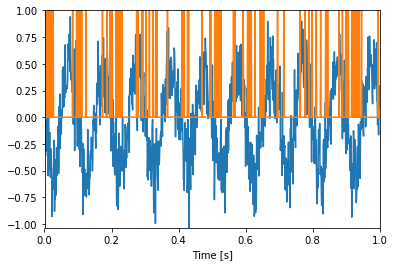

In [3]:
data = sio.loadmat('Ch11-spikes-LFP-1.mat')  # Load the multiscale data,
y = data['y']
t = data['t'].reshape(-1)
n = data['n']
plot(t,y[1,:])                               # ... and visualize it.
plot(t,n[1,:])
xlabel('Time [s]')
plt.autoscale(tight=True)                    # ... with white space minimized.

<div class="alert alert-block alert-warning">
**Array shapes:** The `reshape()` function lets us change the shape of an array. `reshape(-1)` tells Python to reshape the array into a vector with as many elements as are in the array. Mathematically, a vector is a one-dimensional array. In Python, the difference is that a vector is indexed by a single number, while an array is indexed by multiple numbers. After reshaping, we can look at the number at index 0 of `t` using `t[0]`. If we don't reshape first, we need to use `t[0, 0]` to get the same result, so reshaping the array isn't required, but it is more convenient. There is a nice explanation of array shapes [here](https://stackoverflow.com/questions/22053050/difference-between-numpy-array-shape-r-1-and-r#answer-22074424). 
</div>

The data file consists of three variables, which correspond to the LFP data (`y`, in units of millivolts), the simultaneously recorded spiking activity (`n`), and a time axis (`t`, in units of seconds). Notice that the data are arrays, in which each row indicates a separate trial, and each column indicates a point in time. In this case, the variable `n` is binary; `n[k,i]=1` indicates a spike in trial `k` at time index `i`.

<div class="alert alert-block alert-info">
**Q.** What is the sampling frequency for these data? <br><br>

**A.** We are given the time axis `t`. To compute the sampling frequency, we compute the sampling interval: `dt = t[2]-t[1]` and find `dt = 0.001`. The sampling interval is therefore 1 ms, so the sampling frequency ( $f$ ) is $f = 1/dt = 1000$ Hz.

</div>

The data for this trial are plotted in the [figure](#fig:11-1). Visual inspection immediately suggests that the LFP data exhibit a dominant rhythm. By counting the number of peaks (or troughs) in 1 s of data, we estimate the dominant rhythm to be $\approx$ 10 Hz. However, careful inspection suggests that other features appear in the LFP from this first trial of data (i.e., additional lower-amplitude wiggles in the signal). Let’s keep this in mind as we continue the anal- ysis. To visualize the spikes from the neuron, we plot the activity in the first row of the data matrix (orange curve in the [figure](#fig:11-1)); this is a crude representation of the activity but sufficient for the initial inspection.

<div class="alert alert-block alert-info">
**Q.**  Continue your visual inspection for other trials of the data. What do you observe?
</div>

Visual inspection suggests that the neuron is active (i.e., it spikes) during the trial. Of course, we may visualize and analyze features of the spike train and the LFP using the methods described in earlier chapters (e.g., **see problem 1**). However, our goal here is to characterize the relation (if any) between the LFP and spikes. Let’s consider a relatively simple characterization of this relation, the spike-triggered average.

### Spike-Triggered Average<a id="STA"></a>

The *spike-triggered average* (STA) is a relatively simple procedure to visualize the relation between the LFP and spiking data. To compute the STA, we implement the following procedure.

For each trial $k = {1,...,K}$, do the following:

- Identify the time of each spike occurrence $t_{k,i}$, where $i \in \{1,...,N_k\}$, and $N_{k}$ is the number of spikes in the $k^{th}$ trial.


- For each spike time $t_{k,i}$, determine the LFP within a small temporal interval near the spike time $LFP_{k,i}$.-


- Average $LFP_{k,i}$ across all spikes.

Despite this seemingly complicated procedure, the STA is a relatively intuitive measure. The intuition is to find each spike and determine how the LFP changes nearby. The procedure to compute the STA for each trial is relatively straightforward to perform in Python:

In [4]:
win = 100
K = np.shape(n)[0]
N = np.shape(n)[1]
STA = np.zeros([K,2*win+1])
for k in np.arange(K):
    spike_times = np.where(n[k,:]==1)
    counter=0
    for spike_t in np.nditer(spike_times):
        if win < spike_t < N-win-1:
            STA[k,:] = STA[k,:] + y[k,spike_t-win:spike_t+win+1]
            counter += 1
    STA[k,:] = STA[k,:]/counter


In this Python code, we must be careful to include only appropriate time intervals when computing the STA.

<div class="alert alert-block alert-info">
**Q.** Q: What is the purpose of the if-statement:<br><br>

` if win < spike_t < N-win-1:` <br><br>

in the code?
</div>

Notice that the variable `STA` is a matrix, with each row corresponding to a separate trial. Let's plot the results for the STA in four trials<a id="plt:STA"></a>,

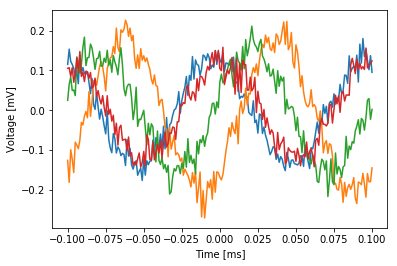

In [5]:
dt = t[1]-t[0]
lags = np.arange(-win,win+1)*dt   # Make a time axis for plotting.
plot(lags, STA[0,:])              # Show the STA for 4 trials.
plot(lags, STA[5,:])
plot(lags, STA[9,:])
plot(lags, STA[15,:])
xlabel('Time [ms]')
ylabel('Voltage [mV]');

And the STA results across all trials,

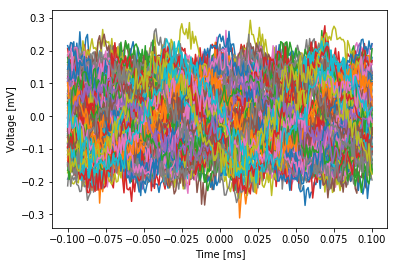

In [6]:
plot(lags,np.transpose(STA))        # Plot the STA results across all trials.
xlabel('Time [ms]')
ylabel('Voltage [mV]');

The individual trial results suggest an approximate rhythmicity in the STA; visual inspection reveals that the STA fluctuates with a period of approximately 100 ms. However, these fluctuations are not phase-locked across trials. For some trials, the LFP tends to be positive when the cell spikes (i.e., at $t = 0$ in the figure), while in other trials the LFP tends to be negative when the cell spikes. The initial results do not suggest a consistent relation exists between the spikes and the LFP across trials.


However, let’s not abandon all hope yet. We might be concerned that the rhythmicity in the STA ([see figure](#plt:STA)) is consistent with the dominant rhythm of the LFP ([see figure](#fig:LFP_ex)). Because the STA is an average of the LFP, we might expect the largest-amplitude features of the LFP to make the biggest impact on the STA. Perhaps this large-amplitude rhythm in the LFP is hiding more subtle features embedded in lower-amplitude activity in the LFP. Let’s continue the search.

<div class="alert alert-block alert-info">
**Q.** How would you update the preceding Python code to compute both the average LFP (i.e., the STA) and the standard deviation of the LFP across spikes for each trial?
</div>

### Field-Triggered Average<a id="FTA"></a>

Let’s now implement another visualization, the field-triggered average (FTA). The FTA is similar in principle to the STA. However, for the FTA, we use the field to organize the activity of the spikes (i.e., we use the field to trigger the spikes). Here we choose a particular feature of the field: the phase. The phase of neural signals is throught to play an [important role in organizing brain activity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4605134/). Now we examine the role of the LFP phase in organizing the spiking activity.


For each trial $k = \{1, \ldots, K\}$,
- Filter the LFP data in trial $k$ into a narrow band, and apply the Hilbert transform to estimate the instantaneous phase.


- Sort the spike data in trial $k$ according to the phase of the LFP.


For more information about the Hilbert transform and instantaneous phase, check out this module discussing [cross-frequency coupling](https://github.com/Mark-Kramer/Case-Studies-Python/tree/master/Cross-Frequency-Coupling). We apply the same procedures here, but to a different end. Let's now define a function to compute the FTA in Python, <a id="fig:FTA"></a>

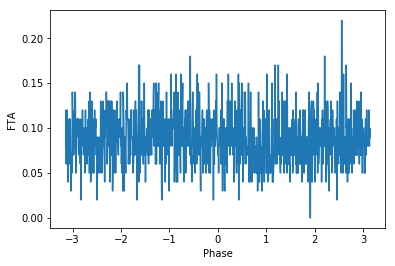

In [7]:
def FTA_function(y,n,t,Wn):                  #INPUTS: y=field, n=spikes, t=time, Wn=passband [low,high]
    dt = t[1]-t[0]                           #Define the sampling interval.
    fNQ = 1/dt/2                             #Define Nyquist frequency.
    ord  = 100                               #...and filter order,
    b = signal.firwin(ord, Wn, nyq=fNQ, pass_zero=False, window='hamming'); #...build bandpass filter.
    FTA=np.zeros([K,N])                      #Create a variable to hold the FTA.
    for k in np.arange(K):                   #For each trial,
        Vlo = signal.filtfilt(b, 1, y[k,:])  # ... and apply filter.
        phi = np.angle(signal.hilbert(Vlo))  # Compute phase of low-freq signal
        indices = np.argsort(phi)            #... get indices of sorted phase,
        FTA[k,:] = n[k,indices]              #... and store the sorted spikes.
    phi_axis = np.linspace(-np.pi,np.pi,N)   #Compute phase axis for plotting.
    return np.mean(FTA,0), phi_axis

Wn = [9,11]                                  #Define the passband, here from 9-11 Hz.
FTA, phi_axis = FTA_function(y,n,t,Wn)       #Compute the FTA.

#Plot the average FTA versus phase.
plot(phi_axis, FTA)
xlabel('Phase')
ylabel('FTA');

Notice the steps to set up the filter. We choose a bandpass filter `Wn`, which here is from 9–11 Hz. We choose this interval to focus on the LFP rhythm of largest amplitude ($\approx 10$ Hz), which we identified through visual inspection ([see figure](#fig:LFP_ex)). For each trial, we apply the filter to the LFP and then use the Hilbert transform (`signal.hilbert`) to estimate the phase. Finally, we sort this phase and use the sorted indices to arrange the spikes and store the results. We show the FTA averaged across all trials in the [figure above](#fig:FTA). In this case, no modulation in the number of spikes is apparent across trials. Instead, the number of spikes at each phase appears equally likely.

We may apply the FTA analysis to different frequency intervals of the LFP. Choosing a frequency interval may be motivated by our knowledge of the neural system generating the activity or by inspection of the field and spiking data.

<div class="alert alert-block alert-info">
**Q.** Investigate different frequency bands in the FTA analysis. Do you observe any interesting features?<br>

$Hint$: Consider frequencies near 45 Hz.
</div>

One final note about the FTA. The purpose of this measure is visualization, not statistical testing. Hopefully, this visual inspection will provide some insight into the data and guide continuing studies in promising directions. In what follows, we consider approaches to test for significant effects when we build a GLM to assess spike-field relations.

### Spike-field coherence 

To characterize the relation between the LFP and spikes, we have so far visualized the data and computed relatively simple and intuitive aids to visualization. Now we examine a more sophisticated and powerful method: the spike-field coherence. It's common to investigate the coherence  applied to field activity; we may refer to this type of coherence as field-field coherence to distinguish it from spike-field coherence of interest here. In practice, this distinction is usually unnecessary, as in most cases the context is clear. However, in this chapter, we are careful to distinguish field-field coherence from spike-field coherence.

The field-field coherence is a frequency domain measure of linear association between two continuous time series. Note that, in practice, we observe a sampled version of a presumably continuous signal. This sampling impacts aspects of our data analysis, for example spectral estimators (see [Analysis of Rhythmic Activity of the Scalp EEG](../Analysis of Rhythmic Activity in the Scalp EEG/Analysis of rhythmic activity in the Scalp EEG.ipynb) and [Analysis of Rhythmic Activity in the Electrocorticogram](../Analysis of rhythmic activity in the Electrocorticogram/Analysis of rhythmic activity in the Electrocorticogram.ipynb). We showed in [REF](to add) that two fields are coherent across trials at frequency $f_0$ if the fields possess a constant phase relation across trials at that frequency. The same relation holds for the spike-field coherence. However, differences arise because of the point process nature of the spike train data. These differences have profound implications with dangerous consequences. In this chapter, we explore some of these issues. For a deeper mathematical discussion and potential solutions, see [Lepage et al, 2011](https://www.ncbi.nlm.nih.gov/pubmed/21671792) and [Lepage et al, 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3800189/).

#### Mathematical Description of spike-field coherence.

Let’s begin with a mathematical description of the spike-field coherence. To do so, we need to introduce some notation, which is identical to that used in earlier chapters, but we include it here for completeness. A more detailed description may be found in [Lepage et al, 2011](https://www.ncbi.nlm.nih.gov/pubmed/21671792).

We considered spectral estimators for a field in [Analysis of Rhythmic Activity of the Scalp EEG](../Analysis of Rhythmic Activity in the Scalp EEG/Analysis of rhythmic activity in the Scalp EEG.ipynb) and for a point process in [REF](to add). We restate the Fourier transform for a time series $x$,

$$
X_j = \sum_{n=1}^N x_n \exp(-2 \pi i \, f_j \, t_n)
$$

where $x_n$ is the signal at time index $t_n = dt \{1, 2, 3, . . . N\}$, and the frequencies $f_j = j/T$, where $j=\{-N/2+1, -N/2+2, \ldots , N/2-1, N/2\}$.  The spectral density of the time series is then,

$$
S_{xx,j} = \frac{2 dt^2}{T} X_j X^*_j .
$$

Here, the time series can be either a field (i.e., the LFP) or a point process (i.e., the spike train).  Notice that we employ the same mathematical formula to compute the  spectrum  for each time series.

<div class="alert alert-block alert-success">
For the spike train data, we first subtract the mean or expected number of spikes in each time interval and then apply the Fourier transform. In other words, the signal is the *centered increments* (see [chapter 8](to add)).
</div>

Then, to estimate the coherence between two time series $x$ and $y$, <a id="eq:field-field-coherence"></a>

$$
\kappa_{xy,j} = \frac{ \mid <S_{xy,j}> \mid }{ \sqrt{<S_{xx,j}>} \sqrt{<S_{yy,j}>}}
\label{eq:SF_k0}
$$

where $\mid <S_{xy,j}> \mid$ indicates the magnitude of the trial averaged cross spectrum, and $\mid <S_{xx,j}> \mid$ and $\mid <S_{yy,j}> \mid$ indicate the magnitude of the trial averaged spectra of $x$ and $y$, respectively.  So far, there's nothing new here;  we've just restated the standard expressions for the spectrum and coherence.  To compute the spike-field cohernece, we simply interpret one of the time series as a point process.  To make this more obvious in our mathematical expression, we replace $x$ in the equation above with the symbol $n$, as a reminder that this time series represents the "number" of spikes,

$$
\kappa_{ny,j} = \frac{ \mid <S_{ny,j}> \mid }{ \sqrt{<S_{nn,j}>} \sqrt{<S_{yy,j}>}}
\label{eq:SF_k}
$$

In the equation above, the numerator is now the magnitude of the trial averaged cross spectrum between the field $y$ and spikes $n$, and the denominator contains the trial averaged spectrum of the spike $n$ and the trial averaged spectrum of the field $y$.

<div class="alert alert-block alert-success">
We could instead write the *sample* coherence, because this equation uses the observed data to estimate the theoretical coherence that we would see if we were to keep repeating this experiment. This distinction is not essential to our goals here, but is important when talking to your statistics-minded colleagues. Throughout this chapter and others, we omit the term "sample" when referring to sample means, variances, covariances, spectra, and so forth, unless this distinction becomes essential to our discussion.
</div>

### Computing the Spike-Field-Coherence in MATLAB.

As discussed in other modules ([Analysis of Rhythmic Activity of the Scalp EEG](../Analysis of Rhythmic Activity in the Scalp EEG/Analysis of rhythmic activity in the Scalp EEG.ipynb) and [Analysis of Rhythmic Activity in the Electrocorticogram](../Analysis of rhythmic activity in the Electrocorticogram/Analysis of rhythmic activity in the Electrocorticogram.ipynb), many issues are involved in spectral analysis, for example, the notions of tapering. These important issues apply for the computation of spike-field coherence as well. In practice, multitaper methods are often used to compute the spike-field coherence. In what follows, we simply a simple tapering approach to the field data.

Let’s now compute the spike-field coherence for the data of interest here. It’s relatively straightforward to do so in Python:

In [8]:
SYY = np.zeros(int(N/2+1))
SNN = np.zeros(int(N/2+1))
SYN = np.zeros(int(N/2+1), dtype=complex)

for k in np.arange(K):
    yf = np.fft.rfft((y[k,:]-np.mean(y[k,:])) *np.hanning(N))    # Hanning taper the field,
    nf = np.fft.rfft((n[k,:]-np.mean(n[k,:])))                   # ... but do not taper the spikes.
    SYY = SYY + ( np.real( yf*np.conj(yf) ) )/K                  # Field spectrum
    SNN = SNN + ( np.real( nf*np.conj(nf) ) )/K                  # Spike spectrum
    SYN = SYN + (          yf*np.conj(nf)   )/K                  # Cross spectrum

cohr = np.real(SYN*np.conj(SYN)) / SYY / SNN                     # Coherence
f = np.fft.rfftfreq(N, dt)                                       # Frequency axis for plotting

Inside of the `for` statement, we first compute the Fourier transform of the field (`yf`) and the spikes (`nf`) for trial `k`. Notice that we subtract the mean from each signal before computing the Fourier transform, and that we apply a Hanning taper to the field data. We estimate the spectra for the field (`SYY`) and the spikes (`SNN`), and the cross spectrum (`SYN`) averaged across all trials. We then compute the coherence (`cohr`) and define a frequency axis to plot the results (`f`).

Let's now display the results, <a id="fig:spike-field-coherence">

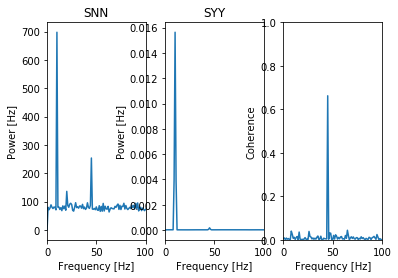

In [9]:
plt.subplot(1,3,1)         # Plot the spike spectrum.
plot(f,SNN)
plt.xlim([0, 100])
xlabel('Frequency [Hz]')
ylabel('Power [Hz]')
title('SNN')

plt.subplot(1,3,2)        # Plot the field spectrum,
T = t[-1]
plot(f,dt**2/T*SYY)       # ... with the standard scaling.
plt.xlim([0, 100])
xlabel('Frequency [Hz]')
ylabel('Power [Hz]')
title('SYY')

plt.subplot(1,3,3)        # Plot the coherence
plot(f,cohr)
plt.xlim([0, 100])
plt.ylim([0, 1])
xlabel('Frequency [Hz]')
ylabel('Coherence');

<div class="alert alert-block alert-info">
<p>**Q:** Consider the spike spectrum, `Snn`, plotted in the figure above. What are the dominant rhythms? At frequencies beyond these dominant rhythms, the spectrum appears to fluctuate around a constant value. What is this constant value?
</p>

<br>
<p>**A.** To answer the first question, we determine through visual inspection of the figure that the dominant rhythm (i.e., the frequency with the most power) occurs at 10 Hz. We also note the presence of a second peak near 45 Hz.<br><br>

To answer the second question, we note that the spike spectrum asymptotes at the expected spike rate (see [chapter 10](add ref)). For these data, we can estimate the expected spike rate as<br><br>

`firing_rate = np.mean(np.sum(n,1))/(N*dt)` <br><br>

Computing this quantity in Python, we find an expected spike rate of approximately 89 Hz, consistent with the high-frequency behavior of `Snn` plotted in the figure.
</div>

<div class="alert alert-block alert-info">
**Q:** onsider the field spectrum, `Syy`, plotted in the figure above. What are the dominant rhythms? Do you observe any other interesting features in this spectrum?<br><br>

**A:** Visual inspection of the figure reveals that the dominant rhythm occurs at 10 Hz. At first glance, no additional spectral features stand out.
</div>

These observations of the spike spectrum and field spectrum reveal that both signals exhibit rhythmic activity at 10 Hz. Therefore, a reasonable place to look for spike-field coherence is near 10 Hz, where both the spikes and the field are rhythmic. However, visual inspection of the spike-field coherence does not indicate coherence at this frequency. Instead, we find a large peak in the spike-field coherence at 45 Hz. Identifying this strong coherence at 45 Hz suggests that we reexamine the spectra. Indeed, careful inspection of the spike spectrum and field spectrum does suggest rhythmic activity at 45 Hz.

<div class="alert alert-block alert-info">
**Q.** What is the approximate value of the *imaginary* part of $X_j$ for $f_j = 10$ Hz? *Hint*: Consider the plot of the product of the sine function and the data.
</div>

<div class="alert alert-block alert-info">
<p>**Q:** Consider the field spectrum on a decibel scale (see [decibel scaling in Analysis of Rhythmic Activity of the Scalp EEG](../Analysis of Rhythmic Activity in the Scalp EEG/Analysis of rhythmic activity in the Scalp EEG.ipynb#decibel-scaling)). What rhythms do you observe?</p>
</div>

<div class="alert alert-block alert-info">
<p>**Q:** Compare the results of your spike-field coherence analysis with the FTA plotted in [this figure](#fig:FTA). How does the peak in the spike-field coherence relate to interesting structure in the FTA?</p>
<div>

The spike-field coherence results again reveal an important feature of coherence analysis. Two signals with high power at the same frequency are not necessarily coherent at this frequency; two signals may possess rhythmic activity at the same frequency, but these rhythms may not coordinate across trials. Conversely, two signals with low power at the same frequency may have strong coherence at that frequency; although the rhythm is weak, the two signals may still coordinate activity across trials at this frequency. These notions apply both to spike-field coherence and field-field coherence (the latter illustrated in [chapter 4](to add)).

The multitaper method to compute the spike-field coherence is a powerful tool in our data analysis arsenal. There’s much more to say about this approach, and interested readers are directed to [Jarvis and Mitra, 2001](https://www.ncbi.nlm.nih.gov/pubmed/11255566), [Lepage et al, 2011](https://www.ncbi.nlm.nih.gov/pubmed/21671792) and [Lepage et al, 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3800189/).

### The Impact of Firing Rate on the Spike-Field Coherence

Often, in the analysis of neural data, we compare the coherence between two pairs of signals. For example, in analysis of scalp EEG data, we might compare the coherence between voltage activity recorded at electrodes A and B with the coherence between voltage activity recorded at electrodes A and C. If we find that electrodes A and B have higher coherence at some frequency than electrodes A and C, we may conclude that the two brain regions A and B coordinate more strongly at this frequency. In this thought experiment, we are comparing the field-field coherence, which is not affected by the amplitude of the signals. For example, if we multiply the amplitude of signal C by a factor of 0.1, the field-field coherence does not change. To gain some intuition for this result, note that in the computation of the coherence ([this equation](#eq:field-field-coherence)), we divide by the spectrum of each signal. In this way, a multiplicative change in signal amplitude appears in the numerator and denominator of the coherence formula and therefore (in this case) factors out.

We might expect the same for spike-field coherence. To test this, let’s manipulate the experimental data provided by our collaborator. We scale the field data by a factor of 0.1 and recompute the spike-field coherence. Scaling the field data is easy to do in Python:

In [10]:
y_scaled = 0.1*y

With this change in the LFP data (`y`), we now recompute the spike-field coherence. To do so, let's first define a function to compute the spike-field coherence,

In [11]:
def coherence(n,y,t):                           #INPUT (spikes, fields, time)
    K = np.shape(n)[0]                          #... where spikes and fields are arrays [trials, time]
    N = np.shape(n)[1]
    T = t[-1]
    SYY = np.zeros(int(N/2+1))
    SNN = np.zeros(int(N/2+1))
    SYN = np.zeros(int(N/2+1), dtype=complex)
    
    for k in np.arange(K):
        yf = np.fft.rfft((y[k,:]-np.mean(y[k,:])) *np.hanning(N))    # Hanning taper the field,
        nf = np.fft.rfft((n[k,:]-np.mean(n[k,:])))                   # ... but do not taper the spikes.
        SYY = SYY + ( np.real( yf*np.conj(yf) ) )/K                  # Field spectrum
        SNN = SNN + ( np.real( nf*np.conj(nf) ) )/K                  # Spike spectrum
        SYN = SYN + (          yf*np.conj(nf)   )/K                  # Cross spectrum

    cohr = np.real(SYN*np.conj(SYN)) / SYY / SNN                     # Coherence
    f = np.fft.rfftfreq(N, dt)                                       # Frequency axis for plotting
    
    return (cohr, f, SYY, SNN, SYN)

Now, with the fucntion `coherence` defined, let's examine how a multiplicative change in the field `y` impacts the spike-field coherence,

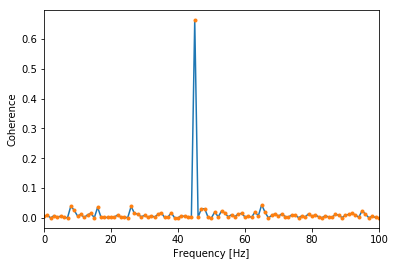

In [12]:
[cohr, f, SYY, SNN, SYN] = coherence(n,y,t)             # Compute spike-field cohernece with original y.
plot(f,cohr)
plt.xlim([0, 100])
[cohr, f, SYY, SNN, SYN] = coherence(n,y_scaled,t)      # Compute spike-field cohernece with scaled y.
plot(f,cohr,'.');
xlabel('Frequency [Hz]')
ylabel('Coherence');

We find that this multiplicative change in the amplitude of the field data does not impact the spike-field coherence. This result is consistent with our intuition from field-field coherence; the height of the field does not matter. Instead, it’s the consistency of the phase relation between two signals across trials that is critical for establishing the coherence.

### Thinning the spike train <a id="sec:thin"></a>

Now, let’s consider manipulating the spiking data. Right away, we notice a difference compared to the field data. In this case, a direct multiplicative change of the spiking data does not make sense. For example, consider multiplying the spike train data (`n`) by a factor of 0.1. Recall that the spike train data consist of two values: 0 or 1. Therefore, the new data after the scaling consist of two values: {0, 0.1} and the interpretation of the variable `n` no longer makes sense. What does it mean to have 0.1 spikes in a time interval?

Instead, to scale the spiking data, we change the average firing rate. We do so in a particular way: by removing spikes from the data, a process we refer to as **thinning**. The [process of thinning](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3800189/) is useful when comparing the spike-field coherence computed for two neurons with different firing rates. A reasonable, intuitive worry is that the firing rate of a neuron will impact the spike-field coherence. For example, we might consider that a neuron with a higher firing rate has the advantage of more opportunities to align with the field and therefore necessarily will possess a larger spike-field coherence. By thinning, we reduce the higher firing rate and establish the two neurons on an equal footing, both with the same opportunity to align with the field. The objective of the thinning procedure is to eliminate the contribution of firing rate differences to the spike-field coherence and allow direct comparison of spike-field coherence results computed for different neurons.

Let’s now thin the spiking data. Here, we implement a simple procedure by randomly selecting and removing spikes from each trial of the spiking data. We assume that in selecting spikes at random to remove, we eliminate both spikes phase-locked to the field and spikes independent of the field. In this way, neither spikes coupled to the LFP nor spikes independent of the LFP receive preferential treatment in the thinning procedure. So, any relations that exist between the spikes and the field are presumably preserved, and we might expect this thinning procedure, on its own, to not affect the spike-field coherence. Let’s define a function to implement this thinning procedure in Python:

In [13]:
def thinned_spike_train(n, thinning_factor):
    n_thinned = np.copy(n)
    for k in np.arange(K):                                # For each trial,
        spike_times = np.where(n[k,:]==1)                 # ...find the spikes.
        n_spikes = np.size(spike_times)                   # ...determine number of spikes.
        spike_times_random = spike_times[0][np.random.permutation(n_spikes)]    # ...permute spikes indices,
        n_remove=int(np.floor(thinning_factor*n_spikes))  # ... determine number of spikes to remove,
        n_thinned[k,spike_times_random[0:n_remove-1]]=0   # remove the spikes.
    return n_thinned

Note that within the `for-loop`, we first find the indices corresponding to spikes in trial `k`. We then randomly permute these indices, and select the appropriate proportion of these indices for removal.

Let's apply this thinning procedure.

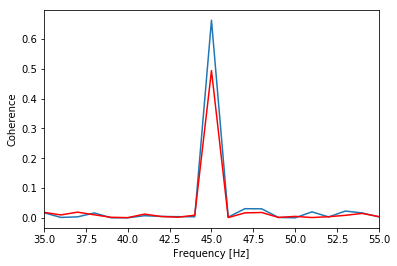

In [14]:
[cohr, f, SYY, SNN, SYN] = coherence(n,y,t)               # Plot the coherence for original spike train.
plot(f,cohr)
[cohr, f, SYY, SNN, SYN] = coherence(thinned_spike_train(n,0.5),y,t)  # ... and for the thinned spike train.
plot(f,cohr, 'r')
plt.xlim([35, 55])
xlabel('Frequency [Hz]')
ylabel('Coherence');

We  plot in the figure above the spike-field coherence for two different levels of thinning, one of which corresponds to the choice of a thinning factor of 0.5. We find that, for the thinned spike train, the peak of spike-field coherence decreases. Why? Intuition suggests that removing spikes at random (i.e., removing spikes coupled to the phase of LFP and removing spikes independent of the LFP) should preserve the spike-field coherence. Perhaps we were unlucky in the thinning procedure and selected to remove more phase-locked spikes than non-phase-locked spikes?

<div class="alert alert-block alert-info">
<p>**Q.** Repeat the analysis with `thinning_factor = 0.5` to select another random batch of spikes to remove. How does the spike-field coherence change compared to the original spike train data? Try this a couple of times, and investigate the peak spike-field coherence at 45 Hz. Is the peak in the spike-field coherence always reduced upon thinning?</p>
</div>

Repeating the thinning procedure and selecting new instances of random spikes to remove preserves the qualitative result. The peak spike-field coherence at 45 Hz decreases. Perhaps we made a conceptual error in the thinning procedure or an error in the MATLAB code? In fact, this result is not a numerical artifact or an error in the code or a problem with the estimate; it’s a property of the spike-field coherence. In [Lepage et al, 2011](https://www.ncbi.nlm.nih.gov/pubmed/21671792) it’s proven that the spike-field coherence depends on the firing rate. An important result from [Lepage et al, 2011](https://www.ncbi.nlm.nih.gov/pubmed/21671792) is:

<div class="alert alert-block alert-success">
As the firing rate tends to zero, so does the spike-field coherence.
</div>

Therefore, we must be very careful when interpreting the spike-field coherence, especially when comparing the spike-field coherence of two neurons with different firing rates. A reduction in spike-field coherence may occur either through a reduction in association between the spikes and the field, or through a reduction in the firing rate with no change in association between the spikes and the field. This is an important and perhaps counter-intuitive result of spike-field coherence. The problems at the end of this module further illustrate this result through simulation. In addition, some procedures exist to mitigate the dependence of spike-field coherence on the firing rate, as discussed in the next section.

<div class="alert alert-block alert-success">
Spike-field coherence responds to overall neural spiking activity, making comparisons between two pairs of spike-field time series difficult when the average spike-rate differs in the two spike-field pairs [Lepage et al, 2011](https://www.ncbi.nlm.nih.gov/pubmed/21671792).
</div>

### Point Process Models of the Spike-Field Coherence

A variety of techniques exist to address the impact of firing rate on the spike-field coher- ence. We have already outlined the thinning procedure, a transformation-based technique in which the firing rates of two neurons are made equal by randomly removing spikes. Here, we focus on an additional technique that utilizes the generalized linear modeling framework. We choose this technique (described in detail in [Lepage et al, 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3800189/)) because it allows us to utilize the GLM framework (see [Module](to add) and [Module](to add)). The fundamental idea of this procedure is to model the conditional intensity of the point process as a function of the LFP phase. More specifically, we consider the model<a id="eq:glm"></a>:

$$
\lambda_t = e^{\beta_0 + \beta_1 \cos(\phi(t)) + \beta_2 \sin(\phi(t))} \, ,
$$

where $\phi(t)$ is the instantaneous phase of a narrowband signal in the LFP.  To compute the phase, we bandpass filter the LFP and apply the Hilbert transform, as described above in our computation of the field-triggered average (FTA).  Then, using the canonical log link, we fit the GLM to the spike train data to estimate the model parameters.  We note that the first parameter $\beta_0$ accounts for the overall activity of the neuron, while the other two parameters $\beta_1$ and $\beta_2$ capture the association between the LFP phase and spiking activity.  In this way, the overall firing rate and the impact of the field on the spiking activity are separately modeled, which mitigates the impact of firing rate on the measure of spike-field association, as we'll see in the next series of examples.

For the analysis of spike-field association, we select a small frequency band of interest, bandpass-filter the field data, and then estimate the phase; the procedures to do so are identical to those used to compute the [FTA](#FTA). Building from those steps, we now focus on the procedures to estimate the phase and GLM in Python:

In [15]:
dt = t[1]-t[0]                     # Define the sampling interval.
fNQ = 1/dt/2                       # Define Nyquist frequency.
Wn = [9,11]                        # Set the passband
ord  = 100                         # ...and filter order,
b = signal.firwin(ord, Wn, nyq=fNQ, pass_zero=False, window='hamming');

phi=np.zeros([K,N])                # Create variable to hold phase.
for k in np.arange(K):             # For each trial,
    Vlo = signal.filtfilt(b, 1, y[k,:])       # ... apply the filter,
    phi[k,:] = np.angle(signal.hilbert(Vlo))  # ... and compute the phase.

n_reshaped   = np.copy(n)
n_reshaped   = np.reshape(n_reshaped,-1)   # Convert spike matrix to vector.
phi_reshaped = np.reshape(phi, -1)         # Convert phase matrix to vector.
                                           # Create a matrix of predictors [1, cos(phi), sin(phi)]
X            = np.transpose([np.ones(np.shape(phi_reshaped)), np.cos(phi_reshaped), np.sin(phi_reshaped)])
Y            = np.transpose([n_reshaped])  # Create a vector of responses.

model = sm.GLM(Y,X,family=sm.families.Poisson())    # Build the GLM model,
res   = model.fit()                                 # ... and fit it.

Note that the variabile definitions and filter settings in the variable `b` are similar to the Python code used to compute the [FTA](#FTA). The difference is that we now store the phases in a matrix (variable `phi`) that we use in the GLM procedure. To fit the GLM, we first collect the spikes and phases across trials into vectors (`n_reshaped` and `phi_reshaped`). Then we define the predictors (`X`, which consist of a constant and functions of the phase) and the response (`Y`, the spikes) and build the model using the function `GLM` and fit the model by calling the function `fit`.

Let's compare the GLM results to the FTA:

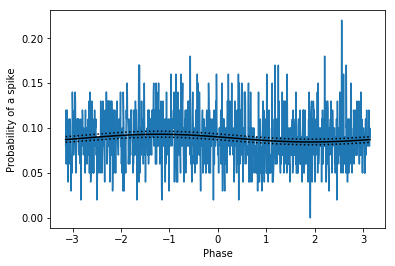

In [16]:
phi_predict = np.linspace(-np.pi, np.pi, 100)
X_predict   = np.transpose([np.ones(np.shape(phi_predict)), np.cos(phi_predict), np.sin(phi_predict)])
Y_predict   = res.get_prediction(X_predict, linear='False')

Wn = [9,11]                                  #Define the passband, here from 9-11 Hz.
FTA, phi_axis = FTA_function(y,n,t,Wn)       #Compute the FTA.

plot(phi_axis, FTA)
plot(phi_predict, Y_predict.predicted_mean, 'k')
plot(phi_predict, Y_predict.conf_int(), 'k:')
xlabel('Phase')
ylabel('Probability of a spike');

The modeling estimates are shown in the figure above: the FTA (identical to [this figure](#fig:FTA)) and the estimates of the GLM (computed using the Python function `get_prediction`). The agreement is excellent. Notice for the 9–11 Hz frequency band the lack of modulation in the estimated conditional intensity, which suggests that the probability of spiking is not affected by the phase of the LFP in the 9–11 Hz frequency range.


Let’s now repeat this analysis but instead bandpass-filter the LFP data for 44–46 Hz; we choose this frequency interval motivated by the spike-field coherence results (see [this figure](#fig:spike-field-coherence)).

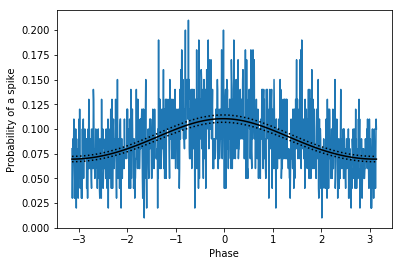

In [17]:
Wn = [44,46]                       # Set the passband
b = signal.firwin(ord, Wn, nyq=fNQ, pass_zero=False, window='hamming');

del phi
phi=np.zeros([K,N])                # Create variable to hold phase.
for k in np.arange(K):             # For each trial,
    Vlo = signal.filtfilt(b, 1, y[k,:])       # ... apply the filter,
    phi[k,:] = np.angle(signal.hilbert(Vlo))  # ... and compute the phase.

n_reshaped   = np.copy(n)
n_reshaped   = np.reshape(n_reshaped,-1)   # Convert spike matrix to vector.
phi_reshaped = np.reshape(phi, -1)         # Convert phase matrix to vector.
                                           # Create a matrix of predictors [1, cos(phi), sin(phi)]
X            = np.transpose([np.ones(np.shape(phi_reshaped)), np.cos(phi_reshaped), np.sin(phi_reshaped)])
Y            = np.transpose([n_reshaped])  # Create a vector of responses.

model = sm.GLM(Y,X,family=sm.families.Poisson())    # Build the GLM model,
res   = model.fit()                                 # ... and fit it,

phi_predict = np.linspace(-np.pi, np.pi, 100)       # ... and evaluate the model results.
X_predict   = np.transpose([np.ones(np.shape(phi_predict)), np.cos(phi_predict), np.sin(phi_predict)])
Y_predict   = res.get_prediction(X_predict, linear='False')

FTA, phi_axis = FTA_function(y,n,t,Wn)       #Compute the FTA, in the new frequency interval

plot(phi_axis, FTA)                          #... and plot it, along with the model fit.
plot(phi_predict, Y_predict.predicted_mean, 'k')
plot(phi_predict, Y_predict.conf_int(), 'k:')
xlabel('Phase')
ylabel('Probability of a spike');


Now, for this frequency interval, we find a modulation of the estimated conditional intensity, with an increase in the probability of a spike near 0 radians. These results illustrate the close correspondence between the FTA and GLM procedures. An important advantage of the GLM approach is the ability to estimate confidence intervals. The confidence intervals in the figure above are estimated in the `get_prediction` function and returned as the outputs `Y_predict.conf_int()`.

For the LFP data filtered at 44–46 Hz, let’s check the significance of the parameters related to the LFP phase, $\beta_1$ and $\beta_2$, via a Wald test (see [chapter 9](add ref)):

In [18]:
pval1=res.pvalues[1];       #Significance of parameter beta_1.
pval2=res.pvalues[2];       #Significance of parameter beta_2.
print(pval1, pval2)

1.4840345290602336e-52 0.7187267797864598


We find that $\beta_1$ is highly significant (`pval1=1.48e-52`) and $\beta_2$ is not significant (`pval2=0.718`), and we conclude that the firing rate is highly dependent on the cosine of the LFP phase.

In [chapter 9](add link), we showed that for nested models (where one model can be made equivalent to the other by setting some parameters to specific values), under the null hypothesis that the data arise from the smaller model, the difference in the deviance between the two models should have a chi-square distribution where the number of degrees of freedom is equal to the number of extra parameters in the larger model. In this case, let’s compare [the model](#eq:glm) to a model that lacks dependence on the LFP phase (i.e., a reduced model in which  $\beta_1$ and $\beta_2$ are set to zero). First, we must construct and estimate this reduced model. In Python,

In [19]:
X0 = np.ones(np.shape(Y))                               #Define constant predictor.
null_model = sm.GLM(Y,X0,family=sm.families.Poisson())  #Define reduced model.
null_res   = null_model.fit()                           #Fit reduced model.

Here `X0` is a constant predictor (consisting of all 1's). Then, to
compute the p-value for this test in Python,

In [20]:
pval = 1-stats.chi2.cdf(null_res.deviance-res.deviance,2) #Compare two nested GLMs.
print(pval)

0.0


<div class="alert alert-block alert-info">
**Q:** Why do we set the second input to the function `stats.chi2.cdf` equal to 2?
</div>

We find `pval=0` and would therefore be very unlikely to see this result if the reduced model (i.e., the model lacking dependence on the LFP phase) were correct.

Finally, let’s examine how thinning the spiking data impacts the results of the GLM procedure. We choose a [thinning factors](#sec:thin) of 0.5 and repeat the analysis for LFP filtered at 44–46 Hz to recompute the FTA and estimate the GLM model.


In [21]:
n_thinned_reshaped   = np.reshape(thinned_spike_train(n,0.5),-1)   # Convert thinned spike matrix to vector.
Y                    = np.transpose([n_thinned_reshaped])          # Create a vector of responses.

thinned_model = sm.GLM(Y,X,family=sm.families.Poisson())           # Build the GLM model,
res_thinned   = thinned_model.fit()                                # ... and fit it.

Let's now compare how the estimates of the exponentiated model parameters ($\beta_0$, $\beta_1$, and $\beta_2$) vary with the thinning factor. As the thinning factor increases, the probability of a spike decreases. This probability can be estimated from the spike train data `n` as

In [22]:
p = np.mean(np.sum(n,1))/N

To compare how the thinning factor impacts the probability of a spike, let's compute the expression above for the original spike train data (`n`) and the thinned spike train, and determine their ratio

In [23]:
(np.mean(np.sum(n_thinned_reshaped))/N) / (np.mean(np.sum(n_reshaped))/N)

0.514420910319964

As expected the ratio of the probabilities is near 0.5, which is consistent with a thinning factor of 0.5.

Now, let's compare the ratios of $\exp(\beta_0)$ estimated for the two models

In [24]:
np.exp(res_thinned.params[0])/np.exp(res.params[0])

0.5142579631497303

We find that this ratio is also near 0.5. We conclude that the two measures - the estimate of probability of a spike and $\exp(\beta_0)$ - are in excellent agreement; as expected, as the thinning factor increases, the probability of a spike decreases.

Finally, let's compare the exponentiated estimates of the other model parameters, $\beta_1$ and $\beta_2$, for the original and thinned spike data. Recall that these parameters represent the impact of the LFP phase on the firing rate.

In [25]:
print([np.exp(res_thinned.params[1]), np.exp(res.params[1])])  # compare ratio of exp(beta_1)
print([np.exp(res_thinned.params[2]), np.exp(res.params[2])])  # compare ratio of exp(beta_2)

[1.2631532469499709, 1.2604558073768588]
[0.9823729024014837, 0.994594076180192]


There are two important features to notice about these estimates:

- First, the thinning factor does not affect these parameter estimates. The changing firing rate is captured in the parameter $\beta_0$ and prevented from impacting the estimates of the spike-field association expressed in the other model parameters.

- Second, the exponentiated parameter $\beta_1$ is well above 1, which indicates a significant association between the cosine phase of the LFP in the 44–46 Hz frequency band and the spiking.

## Summary

In this chapter, we considered associations between data recorded from different spatial scales: the macroscale LFP and the microscale spiking. We developed methods to visualize the associations between scales, and applied tools developed in other chapters, such as the spectrum and coherence. We computed the spike-field coherence and found a strong association between the spatial scales near 45 Hz despite only the weak appearance of this rhythm in the spectra. We also considered the impact of firing rate on the spike-field coherence and illustrated that as the firing rate decreases, so does the spike-field coherence [Lepage et al, 2011](https://www.ncbi.nlm.nih.gov/pubmed/21671792).

To account for the impact of firing rate on coherence we implemented a GLM, in which the firing rate depends on the LFP phase. In general, GLMs provide a powerful tool to estimate spike-field associations. The example considered here illustrates the ability of the GLM framework to estimate the influence of the LFP phase on the spiking and avoid the confounding effect of a changing firing rate. For details describing this approach and its extensions, see [Lepage et al, 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3800189/).
